In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from circle_generator import Circles
from loss import SegmentationLoss, ImageLoss
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt

In [2]:
class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)


class Autoencoder(nn.Module):
    
    def down_conv_module(self, num_input_channels, num_output_channels):
        module = nn.Sequential(
            nn.Conv2d(num_input_channels, num_output_channels, 3, padding=1),
            nn.BatchNorm2d(num_output_channels),
            nn.MaxPool2d(2)
        )
        return module
    
    def up_conv_module(self, num_input_channels, num_output_channels):
        
        module = nn.Sequential(
            nn.ConvTranspose2d(num_input_channels, num_output_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(num_output_channels)
        )
        return module
    
    def conv_module(self, num_input_channels, num_output_channels, kernel_size=3, padding=1):
        module = nn.Sequential(
            nn.Conv2d(num_input_channels, num_output_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(num_output_channels)
        )
        return module
            
    def __init__(self, num_input_channels, num_classes):
        super(Autoencoder, self).__init__()
        down_modules = []
        output_channels = [32, 64, 128]
        input_channels = [num_input_channels, 32, 64]
        
        for in_channels, out_channels in zip(input_channels, output_channels):
            down_modules.append(self.down_conv_module(in_channels, out_channels))
            
        self.down_modules = ListModule(*down_modules)
            
        up_modules = []
        input_channels = [16, 32, 64]
        
        for in_channels, out_channels in zip(output_channels[::-1], input_channels[::-1]):
            up_modules.append(self.up_conv_module(in_channels, out_channels))
            
        self.up_modules = ListModule(*up_modules)
            
        self.conv_image = ListModule(*[self.conv_module(16, 8), self.conv_module(8, num_input_channels)])
        
        self.conv_segmentation = ListModule(*[self.conv_module(16, 8), self.conv_module(8, num_classes, 1, 0)])
        
    
    def forward(self, x):
        for module in self.down_modules:
            x = F.relu(module.forward(x))
        
        for module in self.up_modules:
            x = F.relu(module.forward(x))
        
        x_image = F.relu(self.conv_image[0].forward(x))
        x_image = F.tanh(self.conv_image[1].forward(x_image))
        
        x_segmentation = F.relu(self.conv_segmentation[0].forward(x))
        x_segmentation = self.conv_segmentation[1].forward(x_segmentation)
        
        return x_image, x_segmentation
    

In [3]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)

In [4]:
np.random.seed(42)
batch_sizes = [80, 30, 40]
data = {}
splits = ['train', 'val', 'test']
for batch_size, split in zip(batch_sizes, splits):
    images, segmentation = predata.get_train_batch(batch_size)
    images = Variable(torch.from_numpy(images).float().cuda(0), requires_grad=False)
    segmentation = Variable(torch.from_numpy(segmentation).cuda(0), requires_grad=False)
    data[split] = (images, segmentation)

In [5]:
def train(data, net, number_without_segmentation, num_epoch, img_loss, segm_loss):
    train_loss_history = []
    val_loss_history = []
    
    last_update = 0
    best_val_score = None
    best_model_params = None
    
    optimizer = optim.Adam(net.parameters())
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        optimizer.zero_grad()
        generated_images, generated_segmentation = net.forward(data['train'][0])
        
        train_loss = segm_loss(generated_segmentation[:-number_without_segmentation], 
                               data['train'][1][:-number_without_segmentation])
        train_loss += 1000*img_loss(generated_images, data['train'][0])
        train_loss_history.append(train_loss.data[0])
        
        train_loss.backward()
        optimizer.step()
        
        generated_val_images, generated_val_segmentation = net.forward(data['val'][0])
        val_loss = segm_loss(generated_val_segmentation, data['val'][1])
        val_loss += 1000*img_loss(generated_val_images, data['val'][0])
        val_loss_history.append(val_loss.data[0])
        
        if best_val_score is None or best_val_score > val_loss_history[-1]:
            best_val_score = val_loss_history[-1]
            best_model_params = net.state_dict()
            last_update = 0
        else:
            last_update += 1

        
    net.load_state_dict(best_model_params)
        #print('---- epoch {} -----'.format(epoch))
        #print('loss on train = {}'.format(train_loss_history[-1]))
        #print('loss on validation = {}'.format(val_loss_history[-1]))
        
    return train_loss_history, val_loss_history

In [6]:
net = Autoencoder(num_input_channels=1, num_classes=3).cuda(0)
segm_loss = SegmentationLoss()
img_loss = ImageLoss()
train_loss_history, val_loss_history = train(data, net, 40, 1000, img_loss, segm_loss)

100%|██████████| 1000/1000 [01:06<00:00, 15.01it/s]


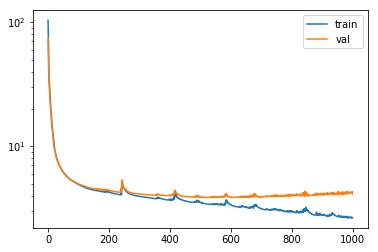

In [7]:
plt.semilogy(train_loss_history, label='train')
plt.semilogy(val_loss_history, label='val')
plt.legend()
plt.show()

In [8]:
generated_images, generated_segmentation = net.forward(data['test'][0])
generated_images = generated_images.cpu().data.numpy()
generated_segmentation = generated_segmentation.cpu().data.numpy()
gt_images = data['test'][0].cpu().data.numpy()
gt_segmentation = data['test'][1].cpu().data.numpy()

In [9]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

/home/aliaksandrashysheya/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


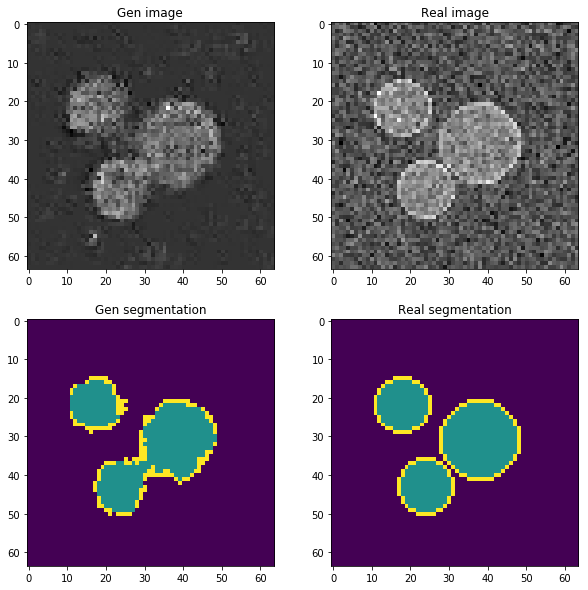

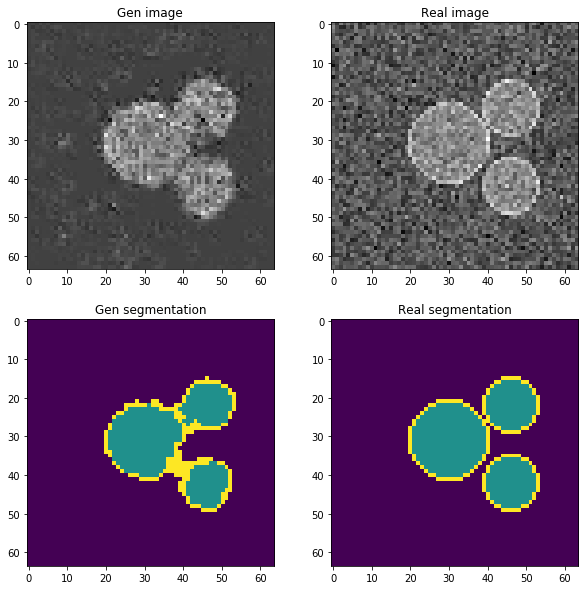

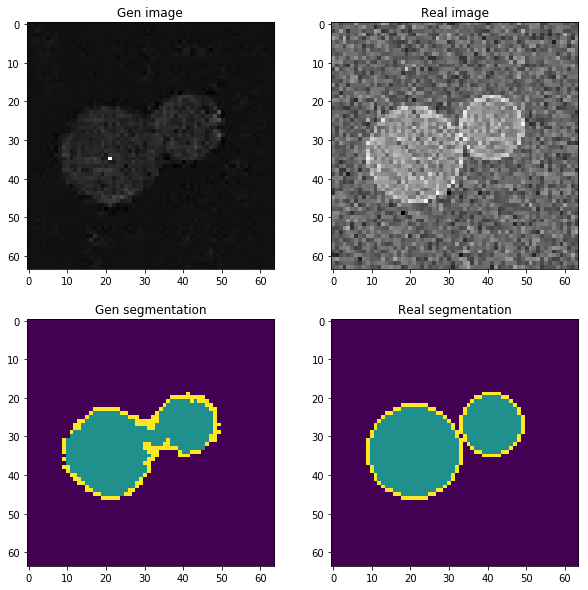

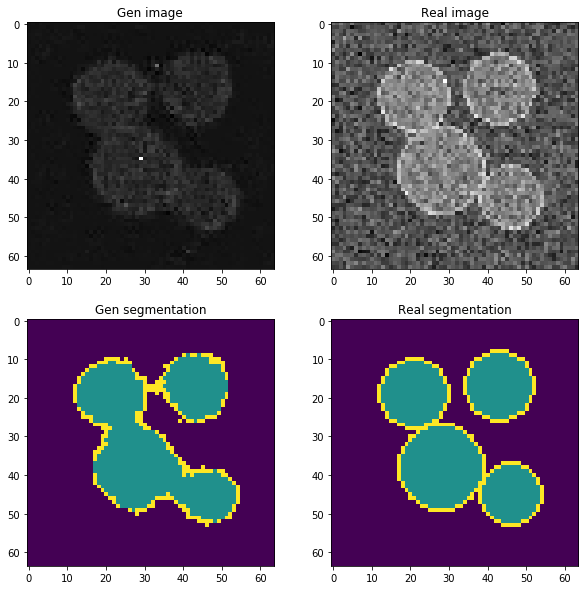

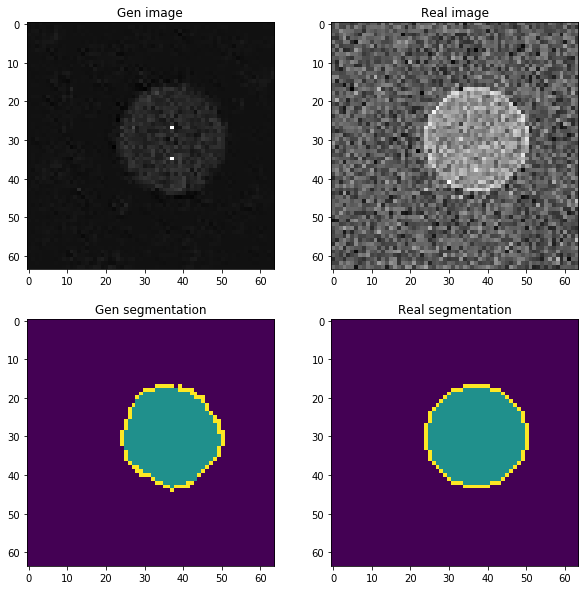

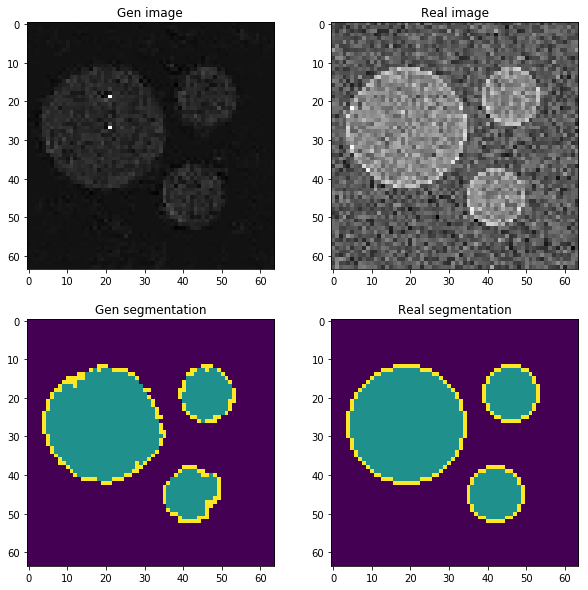

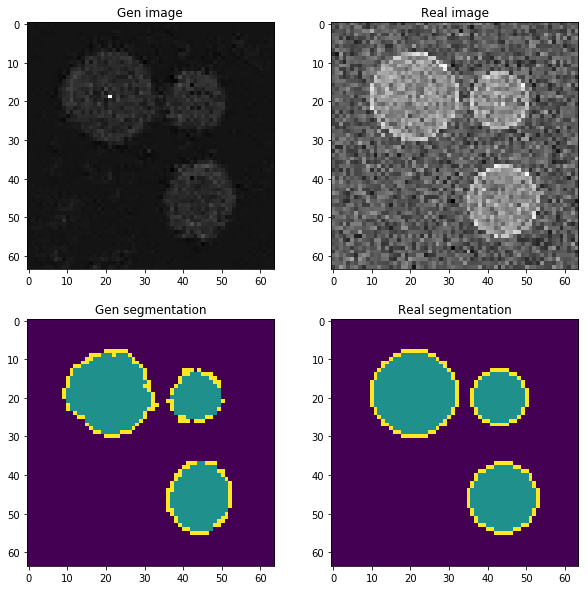

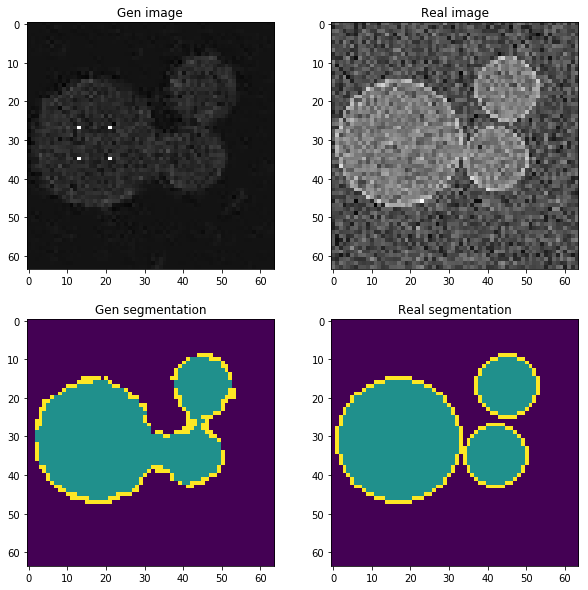

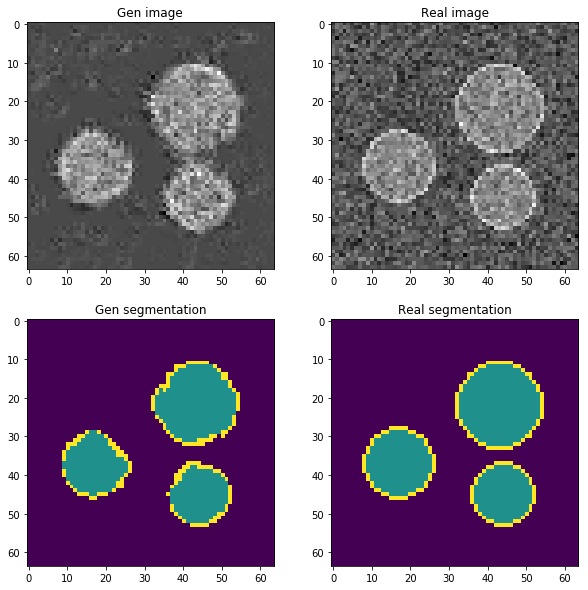

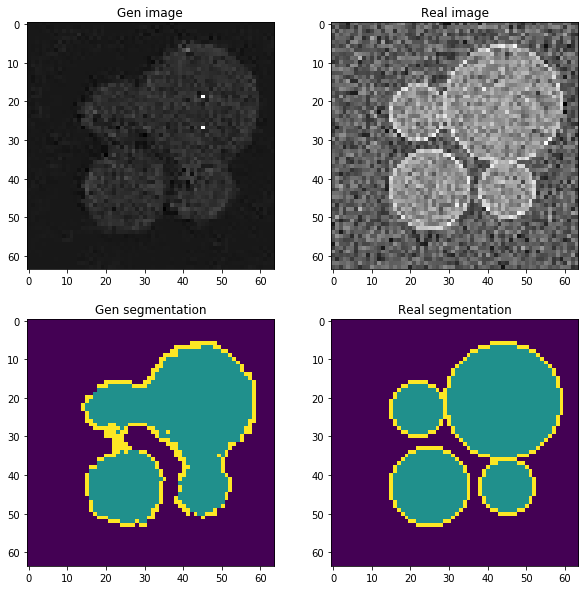

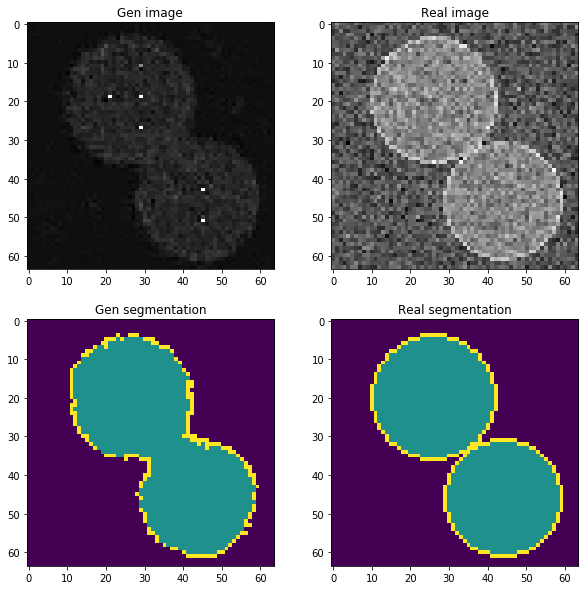

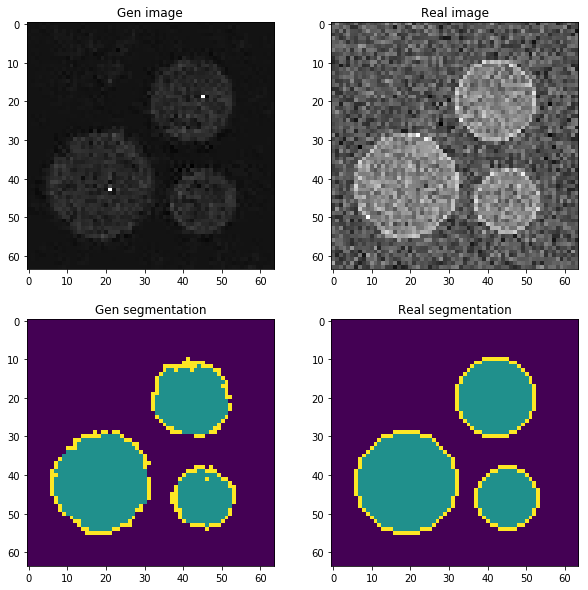

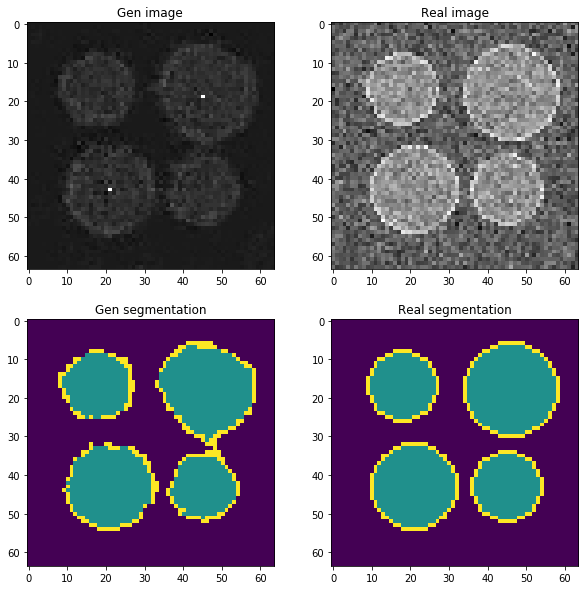

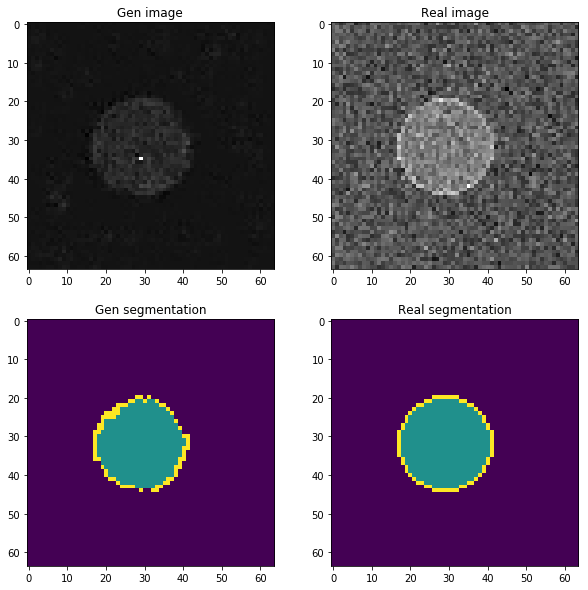

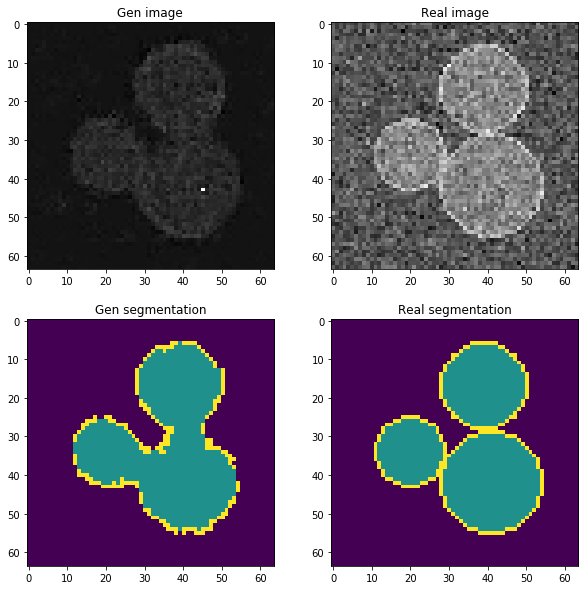

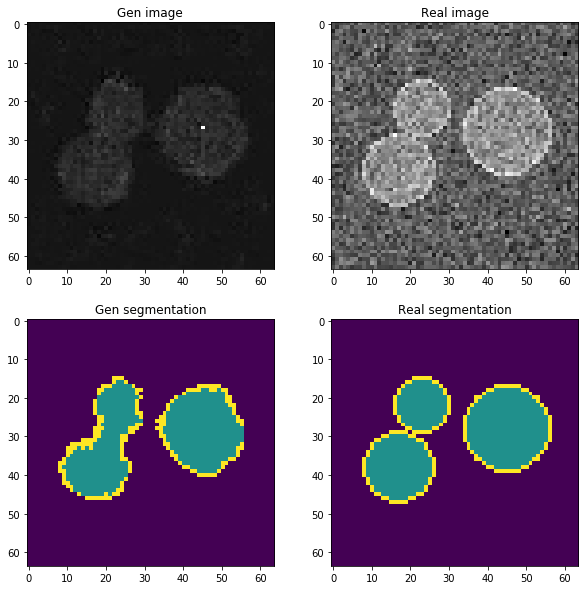

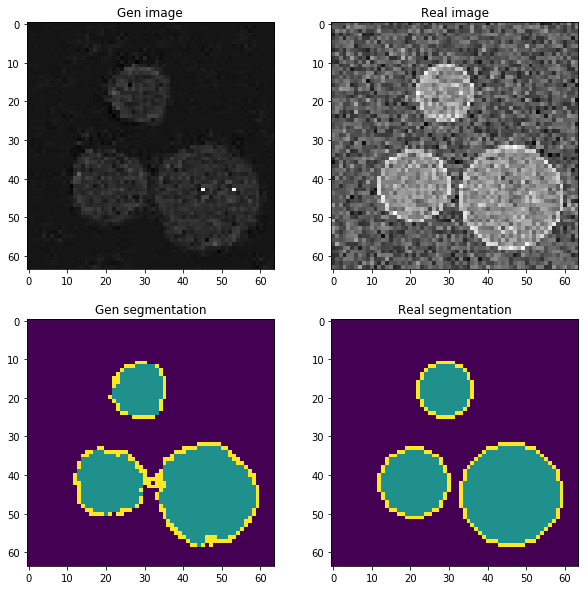

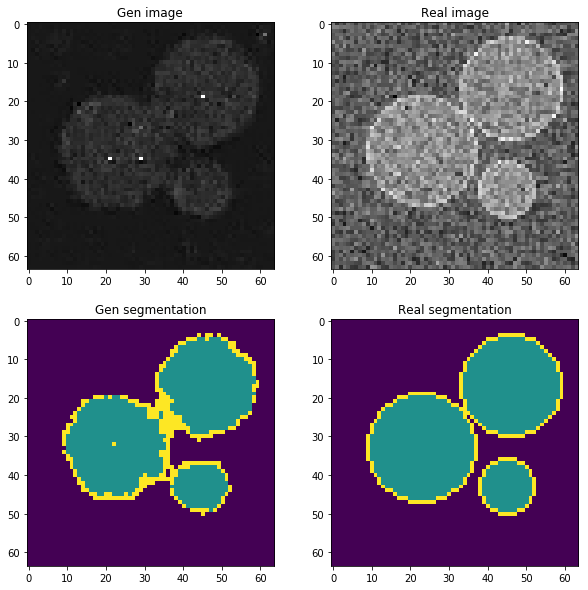

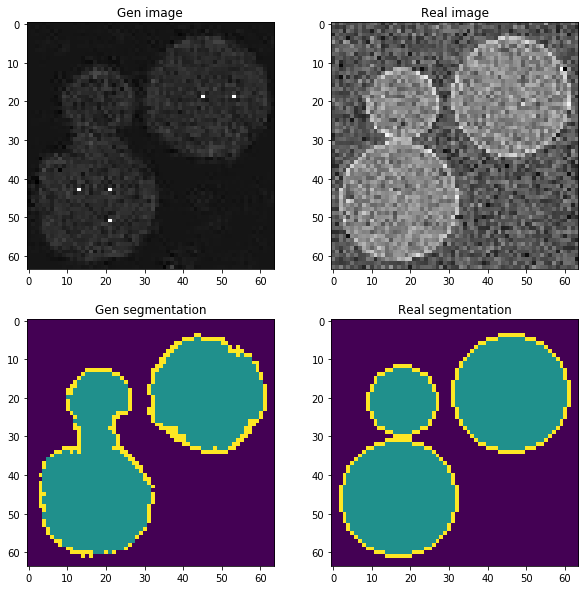

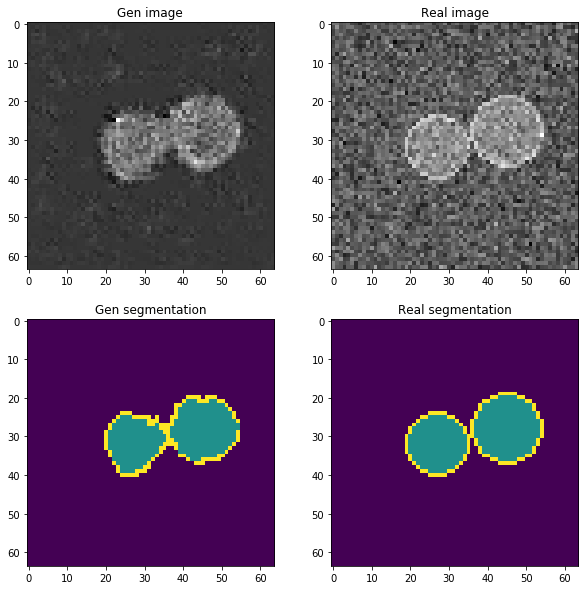

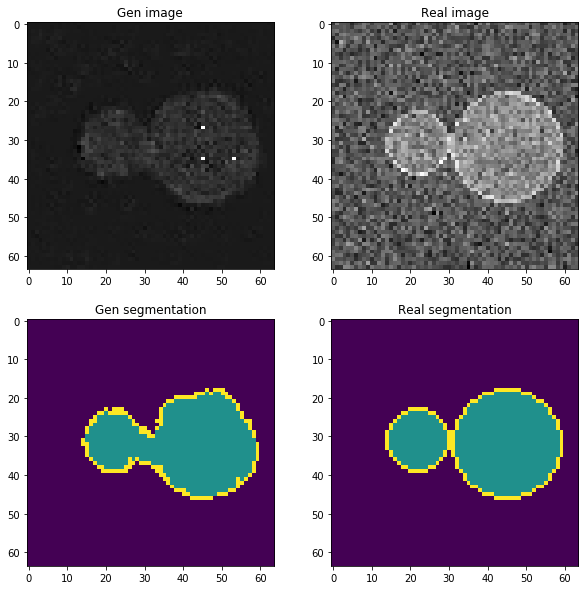

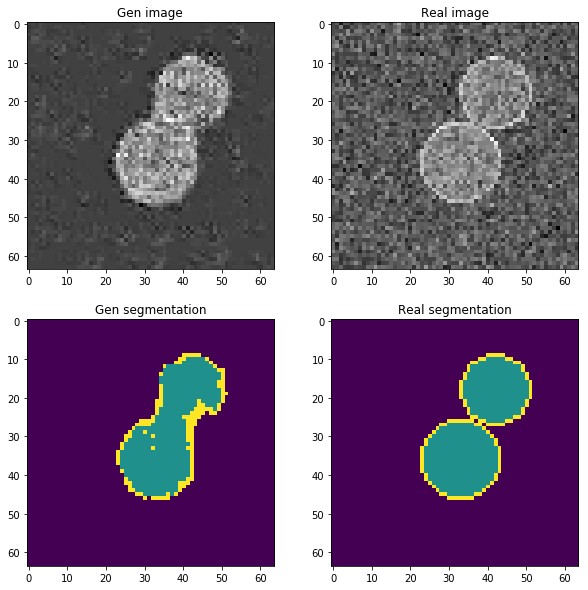

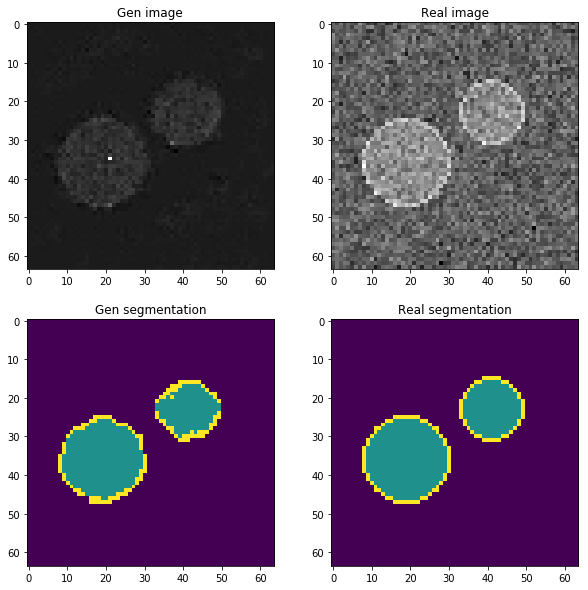

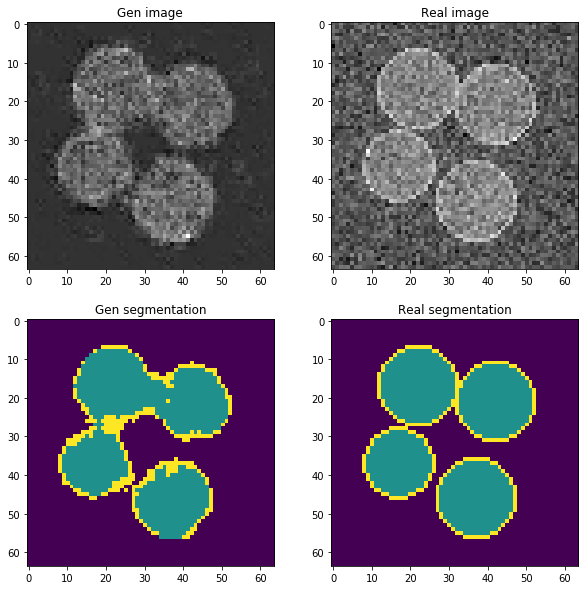

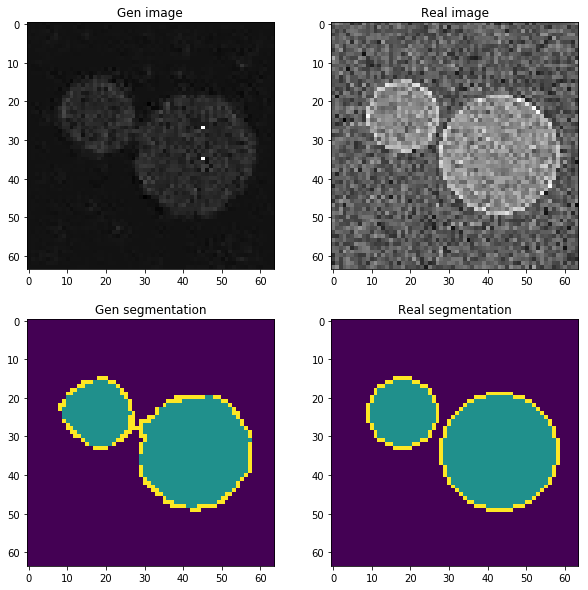

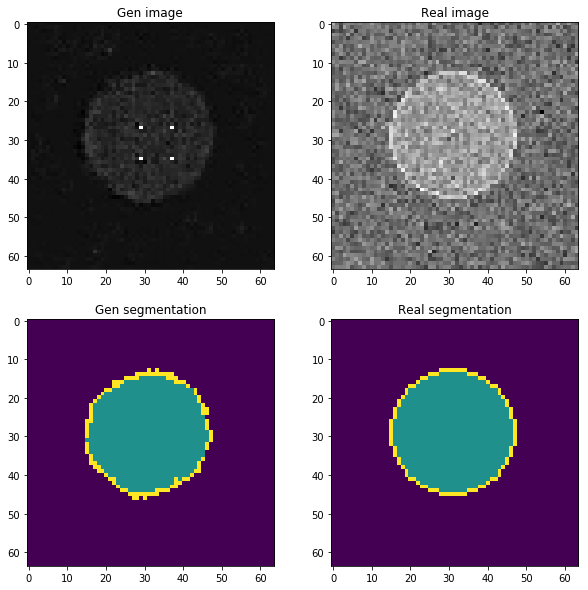

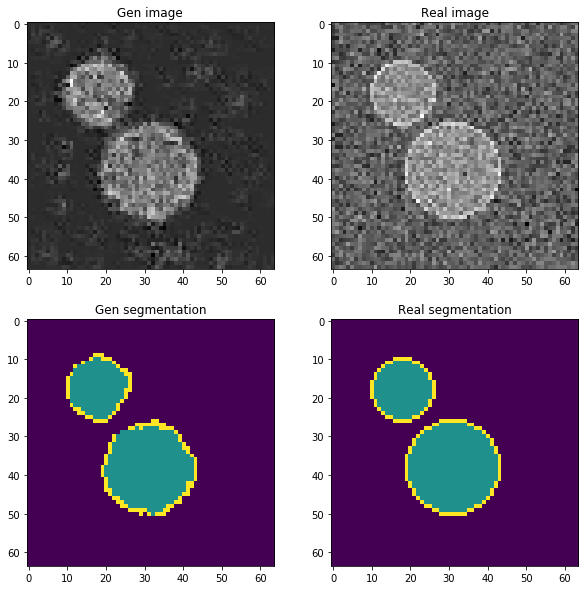

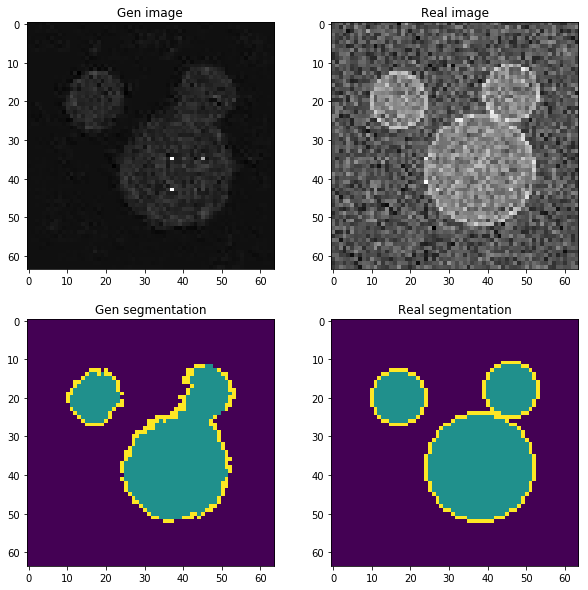

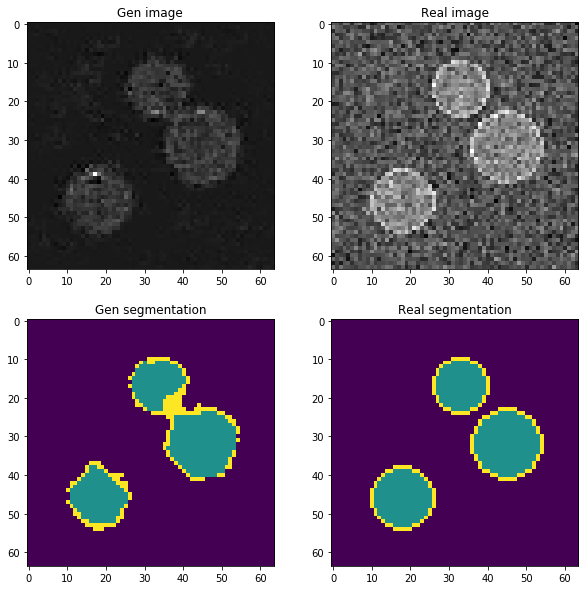

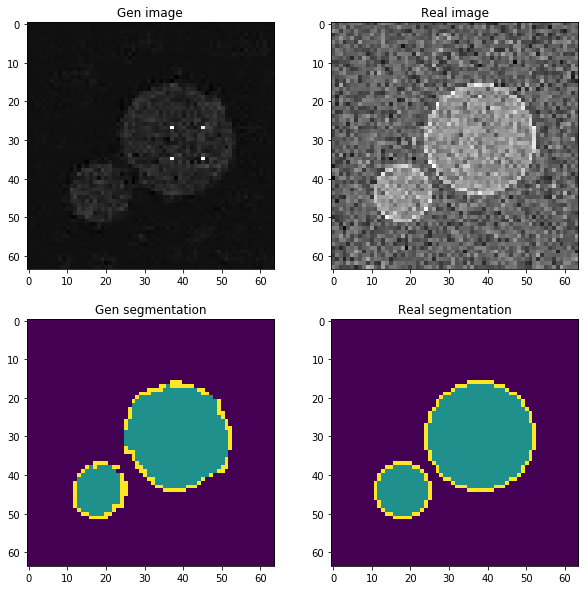

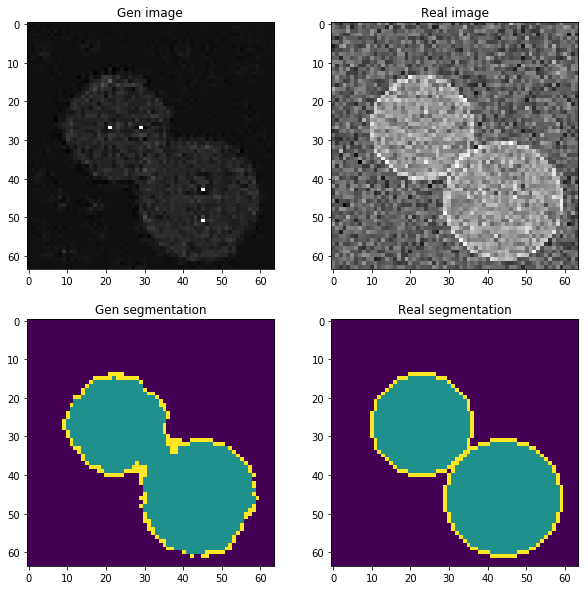

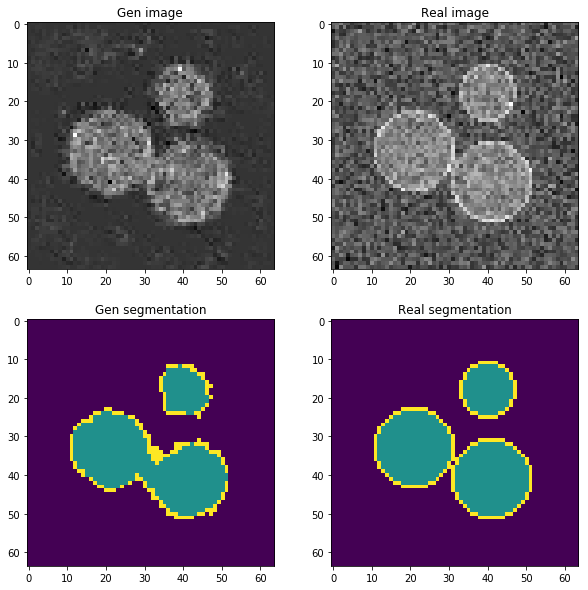

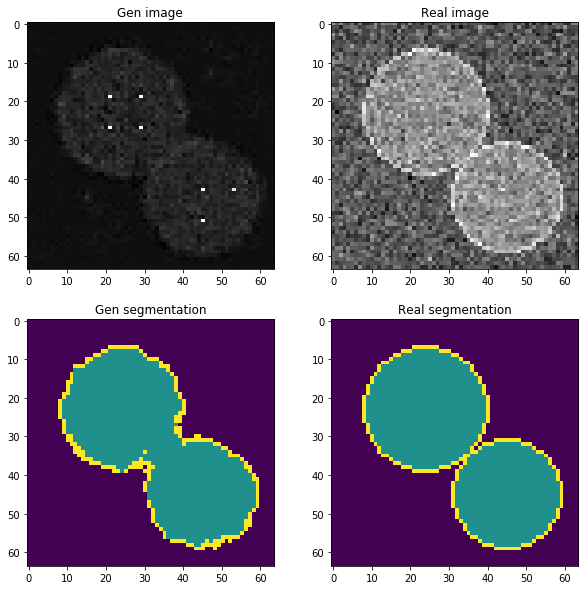

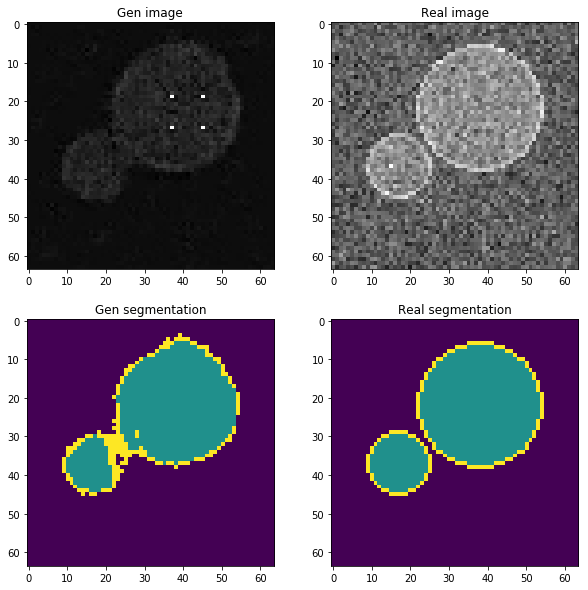

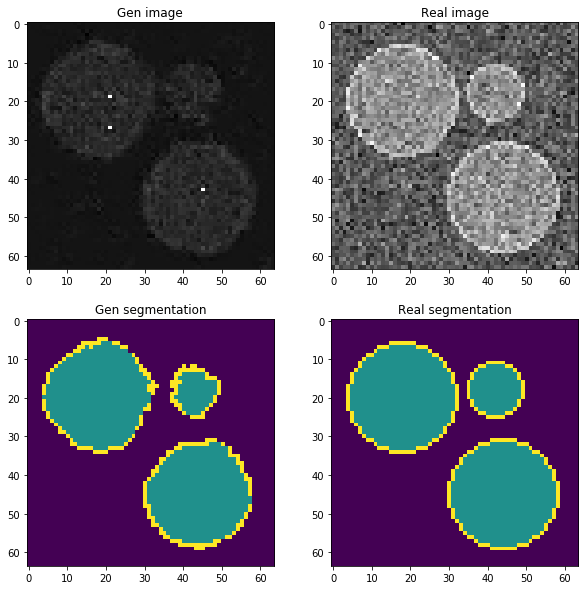

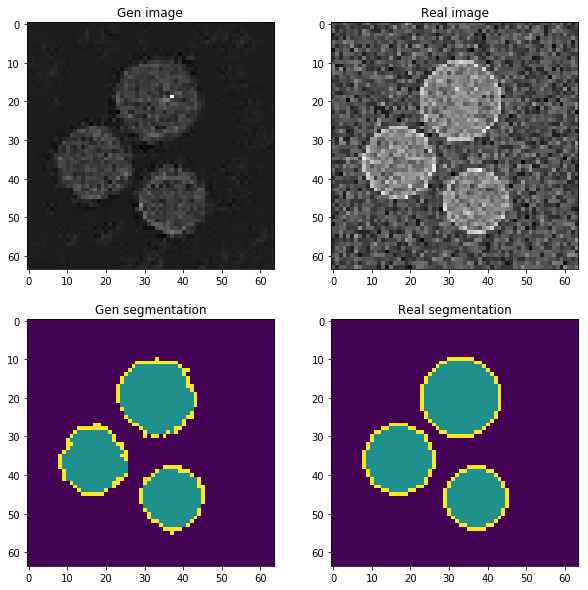

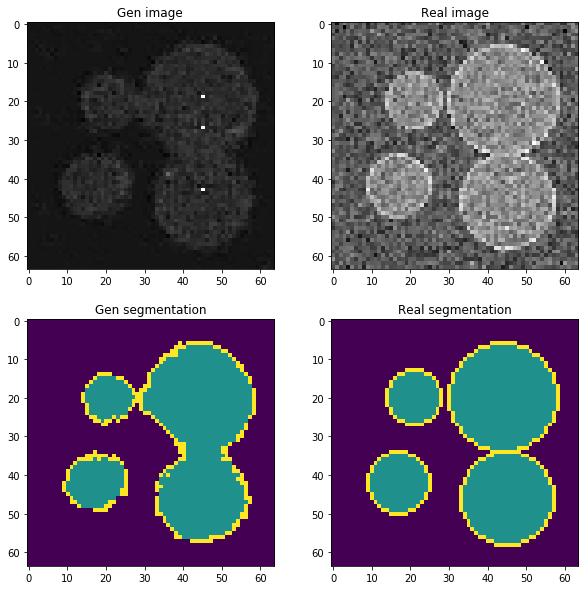

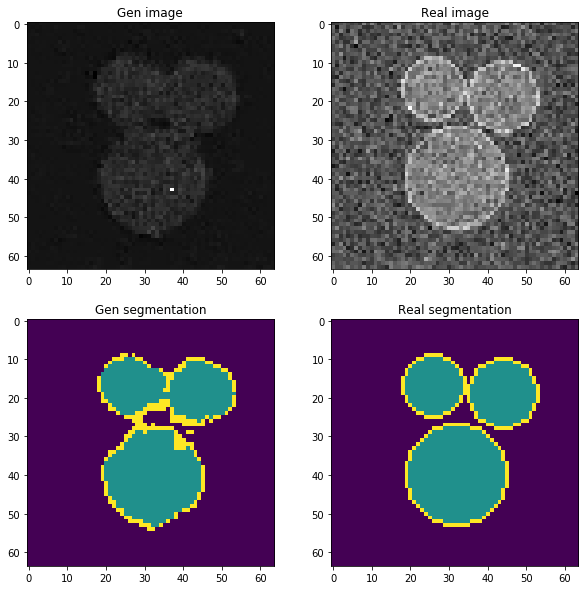

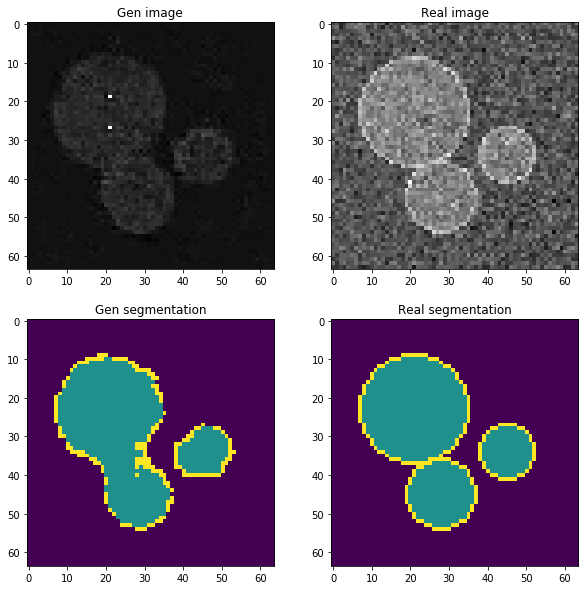

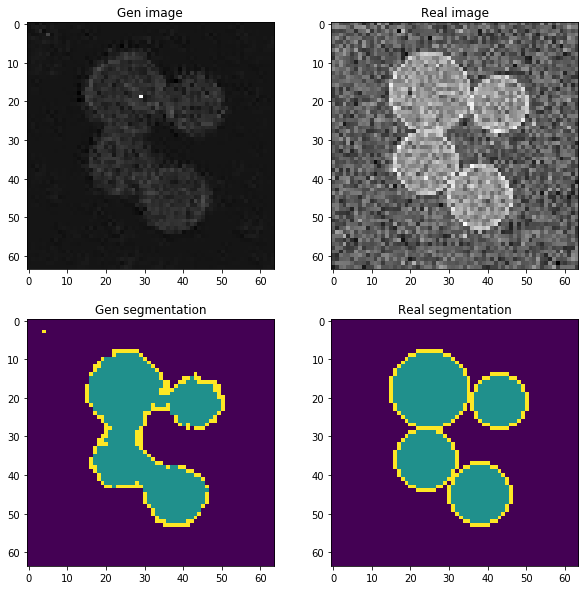

In [10]:
show_image_segm(generated_images, generated_segmentation, gt_images, gt_segmentation)